In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
import statsmodels.api as sm
import missingno as mno

# Load the data

In [9]:
data = pd.read_excel('dataset.xlsx')

# Data Preprocessing and Cleaning

In [10]:
data = data.rename(columns = {'sex(man=1,woman=0)':'sex', 'neck circumference（cm）':'neck', 
                       'waist circumference（cm）':'waist', 
                       'maximum interincisal distance（cm）':'mid', 'Mallampati test':'Mt', 
                       'ratio of Height to thyro-sternum distance':'rhtd', 
                       'ESS questionnaire':'ESS', 'STOP-Bang questionnaire':'SB', 
                       'no or mild OSA: moderate-severe OSA(0:1)':'result'})

In [11]:
#去除NaN
data[['sex', 'age', 'neck', 'waist', 'BMI', 'mid', 'Mt', 'rhtd']].isnull().sum()

sex      0
age      0
neck     0
waist    0
BMI      0
mid      2
Mt       0
rhtd     0
dtype: int64

In [12]:
missing_columns = ['mid']

In [14]:
def random_imputation(df, feature):
    
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace=True)
    
    return df
for feature in missing_columns:
    data[feature + "_imp"] = data[feature]
    data = random_imputation(data, feature)
deter_data = pd.DataFrame(columns=["Det" + name for name in missing_columns])

for feature in missing_columns:
    
    deter_data["Det" + feature] = data[feature + "_imp"]
    parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imp'})
    
    #Create a Linear Regression model to estimate the missing data
    model = linear_model.LinearRegression()
    model.fit(X = data[parameters], y= data[feature + "_imp"])
    
    #Preserve the index of the missing data from the original dataframe
    deter_data.loc[data[feature].isnull(), "Det" + feature] = model.predict(data[parameters])[data[feature].isnull()]

In [15]:
random_data = pd.DataFrame(columns= ["Ran" + name for name in missing_columns])

for feature in missing_columns:
    
    random_data["Ran" + feature] = data[feature + "_imp"]
    parameters = list(set(data.columns) - set(missing_columns) - {feature + '_imp'})
    
    model = linear_model.LinearRegression()
    model.fit(X = data[parameters], y=data[feature + '_imp'])
    
    #Standard error for the regression estimates is equal to std() of the errors of each estimate
    predict = model.predict(data[parameters])
    std_error = (predict[data[feature].notnull()] - data.loc[data[feature].notnull(), feature + '_imp']).std()
    
    #Preserve the index of the missing data from the original dataframe
    random_predict = np.random.normal(size = data[feature].shape[0],
                                      loc = predict,
                                      scale = std_error)
    random_data.loc[(data[feature].isnull()) & (random_predict > 0), "Ran" + feature] = random_predict[(data[feature].isnull()) & (random_predict > 0)]

NameError: name 'dataset' is not defined

<AxesSubplot:>

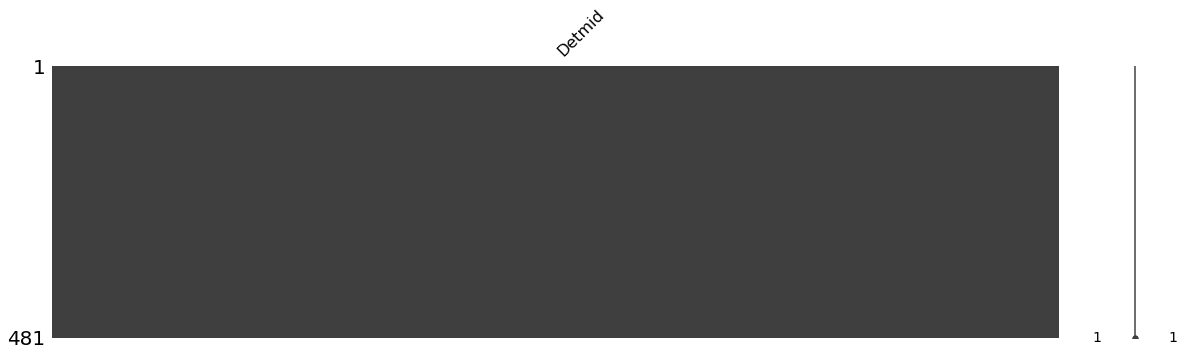

In [ ]:
mno.matrix(deter_data, figsize=(20, 5))

# Modelling

## RandomForestClassifier

In [ ]:
X = data[['sex', 'Mt', 'mid', 'age', 'neck', 'waist', 'BMI', 'rhtd']]
y = data['result']
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)
#RandomForestClassifier
model1 = RandomForestClassifier()
model1.fit(X_trn, y_trn)

ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
y_pred1 = model1.predict(X_tst)
matrix1 = confusion_matrix(y_tst,y_pred1)
confusion_matrix(y_tst, y_pred1)

array([[30,  9],
       [ 3, 54]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

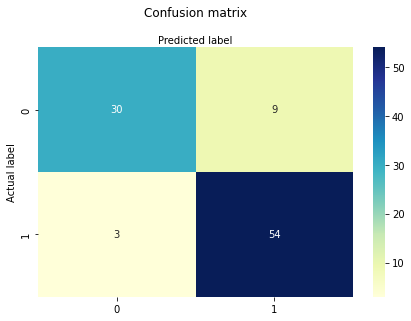

In [ ]:
#混淆矩陣視覺化(Heatmap)
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred1, average =
'macro' )))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred1, average =
'micro')))
print(metrics.classification_report(y_tst, y_pred1))
print(metrics.confusion_matrix(y_tst, y_pred1))

Macro-average: 0.8666666666666667
Micro-average: 0.875
              precision    recall  f1-score   support

           0       0.91      0.77      0.83        39
           1       0.86      0.95      0.90        57

    accuracy                           0.88        96
   macro avg       0.88      0.86      0.87        96
weighted avg       0.88      0.88      0.87        96

[[30  9]
 [ 3 54]]


## ExtraTreesClassifier

In [ ]:
model2 = ExtraTreesClassifier()
model2.fit(X_trn, y_trn)

ExtraTreesClassifier()

In [ ]:
y_pred2 = model2.predict(X_tst)
matrix2 = confusion_matrix(y_tst,y_pred2)
confusion_matrix(y_tst, y_pred2)

array([[30,  9],
       [ 5, 52]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

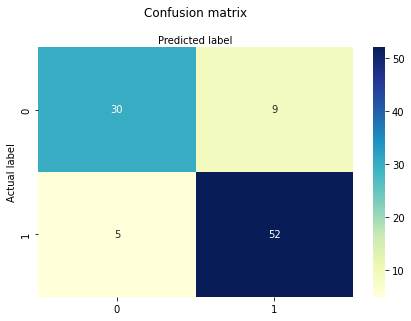

In [ ]:
#混淆矩陣視覺化(Heatmap)
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix2), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred2, average =
'macro' )))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred2, average =
'micro')))
print(metrics.classification_report(y_tst, y_pred2))
print(metrics.confusion_matrix(y_tst, y_pred2))

Macro-average: 0.8460833715071003
Micro-average: 0.8541666666666666
              precision    recall  f1-score   support

           0       0.86      0.77      0.81        39
           1       0.85      0.91      0.88        57

    accuracy                           0.85        96
   macro avg       0.85      0.84      0.85        96
weighted avg       0.85      0.85      0.85        96

[[30  9]
 [ 5 52]]


## BaggingClassifier

# Feature Selection

In [ ]:
X = data[['sex', 'age', 'neck', 'waist', 'BMI', 'mid', 'Mt', 'rhtd']]
y = data['result']

### Univariate

In [ ]:
#Select the best features
bestfeatures = SelectKBest(score_func=chi2, k='all')
fit = bestfeatures.fit(X ,y)
dfscore = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization
featureScores = pd.concat([dfcolumns,dfscore], axis=1)
featureScores.columns = ['Features', 'Score'] #naming the dataframe columns
print(featureScores.nlargest(8, 'Score')) #print 5 best features

  Features      Score
1      age  60.651793
3    waist  53.835420
7     rhtd  28.745181
2     neck  13.472711
4      BMI  11.887127
0      sex   6.712449
6       Mt   1.823707
5      mid   0.767744


### Feature importance

[0.0478486  0.14486206 0.13059873 0.16062937 0.15293613 0.1027225
 0.06724133 0.19316127]


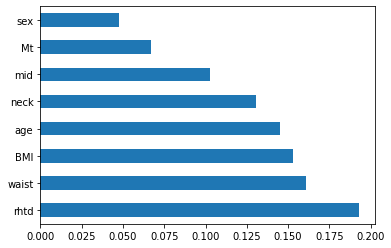

In [ ]:
model = ExtraTreesClassifier()
model.fit(X,y)
print(model.feature_importances_)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(8).plot(kind ='barh')
plt.show()

[0.02897165 0.15578042 0.11914358 0.17251764 0.17528182 0.07272805
 0.04377287 0.23180396]


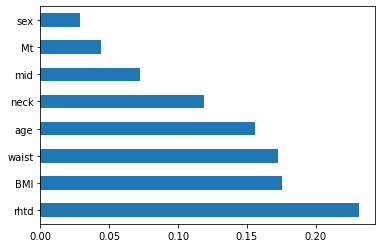

In [ ]:
rf_model = RandomForestClassifier()
rf_model.fit(X, y)
print(rf_model.feature_importances_)
feat_importances = pd.Series(rf_model.feature_importances_, index = X.columns)
feat_importances.nlargest(8).plot(kind = 'barh')
plt.show()

### Correlation Matrix with Heatmap

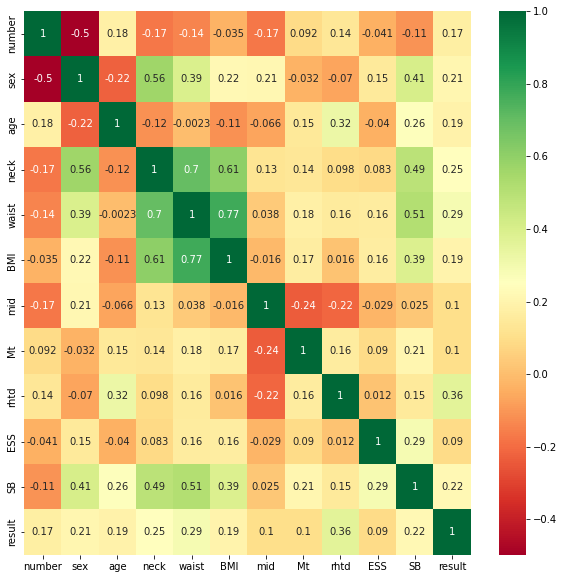

In [ ]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10, 10))
# Plot heat map
g = sns.heatmap(data[top_corr_features].corr(), annot=True, cmap="RdYlGn")

In [ ]:
bagging = BaggingClassifier(RandomForestClassifier(), n_estimators=10)
bagging.fit(X_trn, y_trn)

BaggingClassifier(base_estimator=RandomForestClassifier())

In [ ]:
y_pred3 = bagging.predict(X_tst)
matrix3 = confusion_matrix(y_tst,y_pred3)
confusion_matrix(y_tst, y_pred2)

array([[30,  9],
       [ 5, 52]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

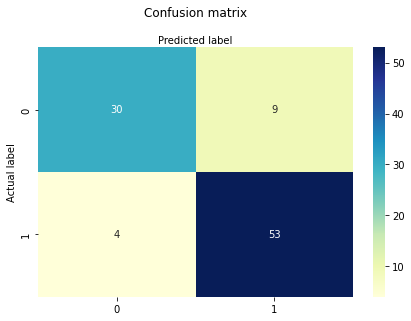

In [ ]:
#混淆矩陣視覺化(Heatmap)
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix3), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred3, average =
'macro' )))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred3, average =
'micro')))
print(metrics.classification_report(y_tst, y_pred3))
print(metrics.confusion_matrix(y_tst, y_pred3))

Macro-average: 0.8563370553700933
Micro-average: 0.8645833333333333
              precision    recall  f1-score   support

           0       0.88      0.77      0.82        39
           1       0.85      0.93      0.89        57

    accuracy                           0.86        96
   macro avg       0.87      0.85      0.86        96
weighted avg       0.87      0.86      0.86        96

[[30  9]
 [ 4 53]]


# Tuning

In [ ]:
X = data[['sex', 'Mt', 'mid', 'age', 'neck', 'waist', 'BMI', 'rhtd']]
y = data['result']
X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, test_size=0.2, random_state=42)
#RandomForestClassifier
model1 = RandomForestClassifier()
model1.fit(X_trn, y_trn)

RandomForestClassifier()

In [ ]:
y_pred1 = model1.predict(X_tst)
matrix1 = confusion_matrix(y_tst,y_pred1)
confusion_matrix(y_tst, y_pred1)

array([[28, 11],
       [ 3, 54]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

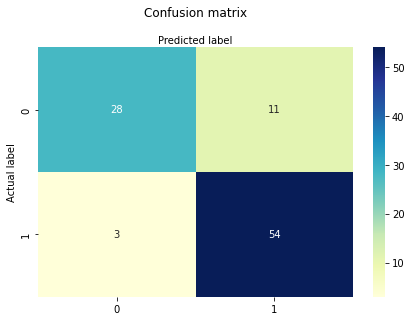

In [ ]:
#混淆矩陣視覺化(Heatmap)
%matplotlib inline
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(matrix1), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Macro-average: {0}".format(metrics.f1_score(y_tst, y_pred1, average =
'macro' )))
print("Micro-average: {0}".format(metrics.f1_score(y_tst, y_pred1, average =
'micro')))
print(metrics.classification_report(y_tst, y_pred1))
print(metrics.confusion_matrix(y_tst, y_pred1))

Macro-average: 0.8426229508196722
Micro-average: 0.8541666666666666
              precision    recall  f1-score   support

           0       0.90      0.72      0.80        39
           1       0.83      0.95      0.89        57

    accuracy                           0.85        96
   macro avg       0.87      0.83      0.84        96
weighted avg       0.86      0.85      0.85        96

[[28 11]
 [ 3 54]]
